# Manual Exploration, Pre-processing and Feature Engineering steps

Welcome to the **Preprocessing** phase of our Employee Attrition Predictive Modeling project. This notebook is dedicated to manually exploring data cleaning, feature engineering, and preprocessing techniques that are critical for building a robust predictive model. Here, we make informed assumptions about the most appropriate methods for transforming our data and prepare the groundwork for our subsequent modeling experiments.

## Notebook Overview

Employee attrition is a key indicator of organizational health. Predicting which employees are likely to leave enables organizations to proactively address retention challenges. Our project leverages a combination of statistical techniques and machine learning methods to forecast attrition. In this notebook, we focus on:

- **Data Cleaning:** Removing noise, handling missing values, dropping non-informative columns, and eliminating duplicates.
- **Outlier Detection:** Comparing univariate (IQR) and multivariate (Isolation Forest) methods to identify extreme values while preserving valuable real-world variations.
- **Exploratory Data Analysis (EDA):** Visualizing feature distributions, examining correlations, and assessing collinearity.
- **Feature Engineering:** Creating new attributes (e.g., `AgeAtJoining`, `TenureRatio`, `IncomePerYearExp`) and transforming skewed features using log and Box-Cox transformations.
- **Scaling and Encoding:** Testing scaling methods (standardization vs. MinMax) and encoding strategies (one-hot and alternative ordinal encoding for specific features).
- **Balancing Classes:** Using SMOTE to oversample the underrepresented class and address class imbalance.
- **Feature Selection:** Employing techniques like LassoCV, RFE, and Random Forest feature importance (with a median threshold) to select the most predictive features.
- **Baseline Modeling:** Running a Gradient Boosting classifier as an initial benchmark.


## Note on the Purpose of this Notebook

In this notebook, our goal is to make informed assumptions on which preprocessing techniques might work best for our various classification models. Although these steps are based on sound reasoning and initial exploratory analysis, we will later put each of these assumptions to the test by integrating them into automated pipelines and systematically evaluating their performance.



In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [42]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
print("Initial data shape:", df.shape)

Initial data shape: (1470, 35)


# Data Cleaning

We start by examining the shape, structure, and basic statistics of the dataset to understand its composition.

In [43]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [45]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


#### Dropping non-Informative Columns

In this step, we remove the columns `EmployeeCount`, `StandardHours`, and `EmployeeNumber` from the DataFrame. These columns are dropped because:

- **EmployeeCount:** Constant value of 1 across all records, offering no useful information for analysis.
- **StandardHours:** Remains the same for every employee at 80h, and thus does not contribute to model variance.
- **EmployeeNumber:** Serves as an identifier and does not provide any predictive value.

By eliminating these columns, we reduce noise in the dataset and focus only on the features that contribute meaningful information for our predictive modeling.

In [46]:

df.drop(columns=['EmployeeCount', 'StandardHours','EmployeeNumber'], inplace=True)
print("Columns after dropping:", df.columns)


Columns after dropping: Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


#### Checking for Missing Values

Before applying any imputation strategies, we first assess the dataset for missing values using the `isnull().sum()` method. 

Although our current dataset shows **0 null values**, we plan to incorporate imputation steps in our modeling pipelines to handle any future missing data. This is essential to ensure that we do not lose valuable employee records.

For future data, our imputation strategy will include:

- **Numerical Features:** Impute missing values using the **median**.
- **Categorical and Ordinal Features:** Impute missing values using the **mode**.

By embedding these steps in our pipeline, we ensure robust handling of missing values, keeping all employee instances intact for analysis.

In [47]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

#### Removing Duplicates, if any

In [48]:
df.drop_duplicates(inplace=True)
print("After removing duplicates:", df.shape)

After removing duplicates: (1470, 32)


### Outlier Detection

#### IQR

Age: 0 potential outliers (lower_bound=10.50, upper_bound=62.50)


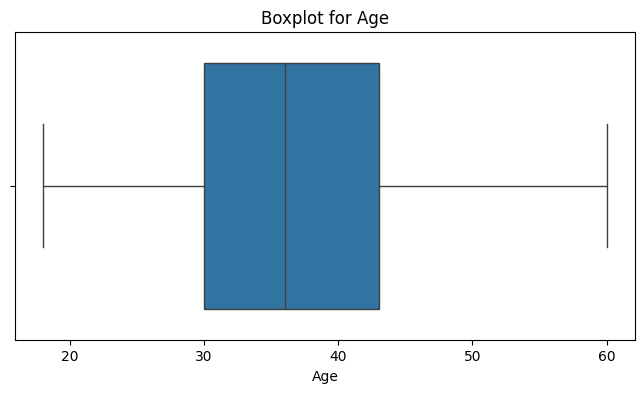

DailyRate: 0 potential outliers (lower_bound=-573.00, upper_bound=2195.00)


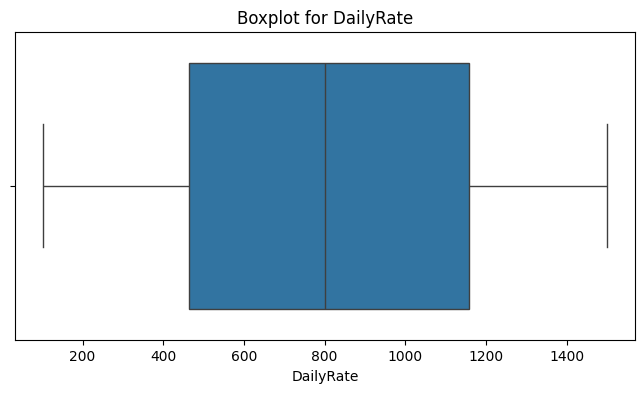

DistanceFromHome: 0 potential outliers (lower_bound=-16.00, upper_bound=32.00)


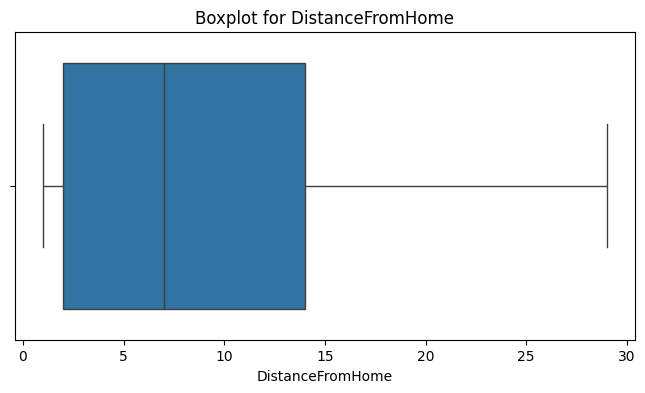

Education: 0 potential outliers (lower_bound=-1.00, upper_bound=7.00)


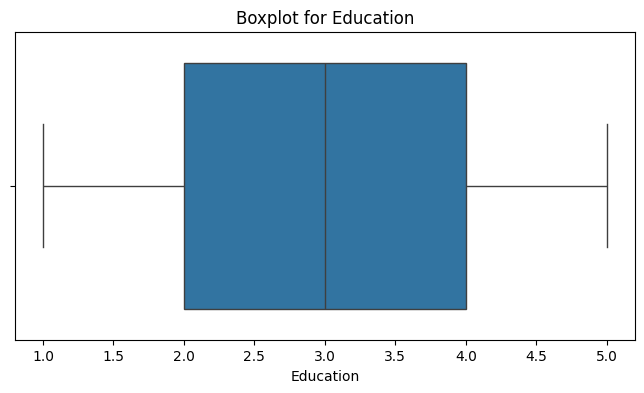

EnvironmentSatisfaction: 0 potential outliers (lower_bound=-1.00, upper_bound=7.00)


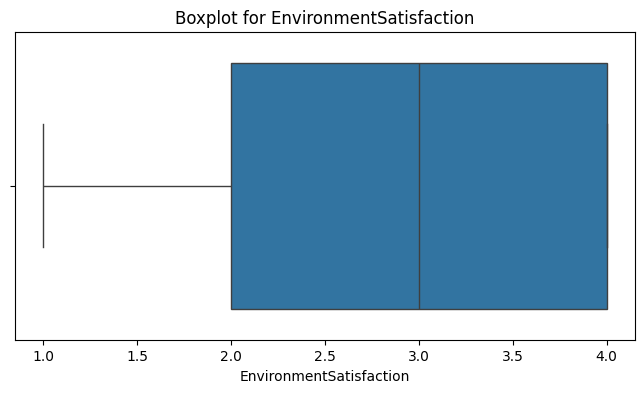

HourlyRate: 0 potential outliers (lower_bound=-5.62, upper_bound=137.38)


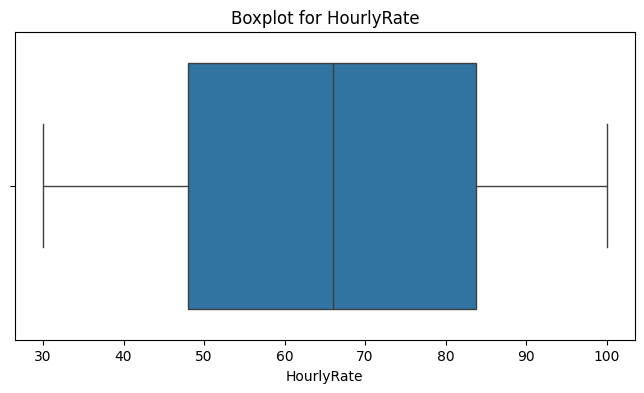

JobInvolvement: 0 potential outliers (lower_bound=0.50, upper_bound=4.50)


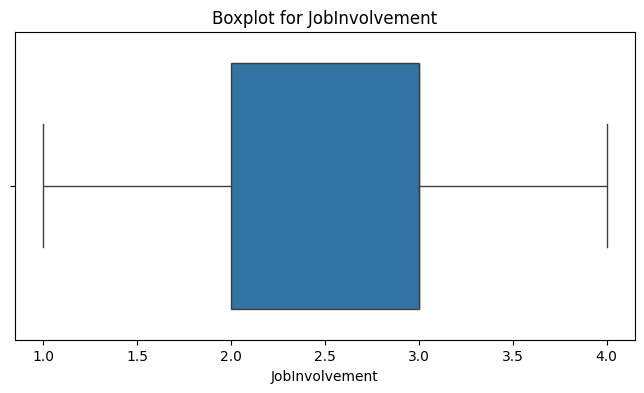

JobLevel: 0 potential outliers (lower_bound=-2.00, upper_bound=6.00)


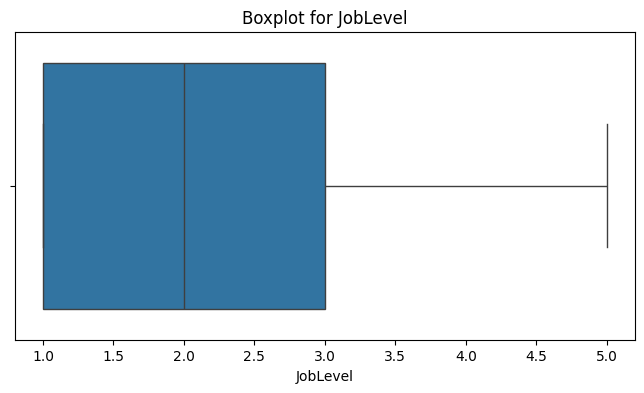

JobSatisfaction: 0 potential outliers (lower_bound=-1.00, upper_bound=7.00)


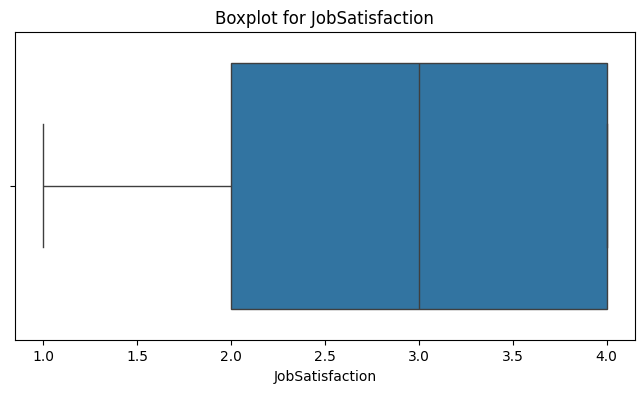

MonthlyIncome: 114 potential outliers (lower_bound=-5291.00, upper_bound=16581.00)


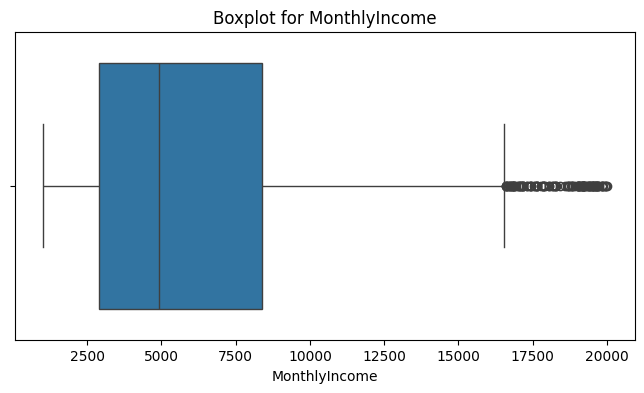

MonthlyRate: 0 potential outliers (lower_bound=-10574.75, upper_bound=39083.25)


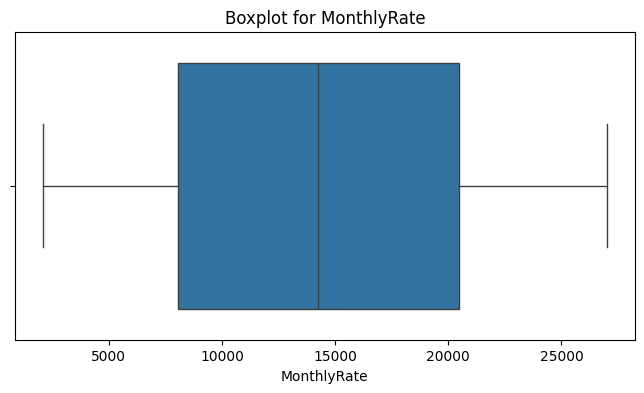

NumCompaniesWorked: 52 potential outliers (lower_bound=-3.50, upper_bound=8.50)


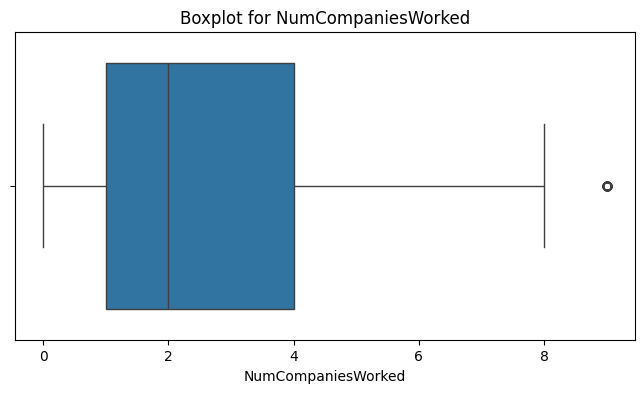

PercentSalaryHike: 0 potential outliers (lower_bound=3.00, upper_bound=27.00)


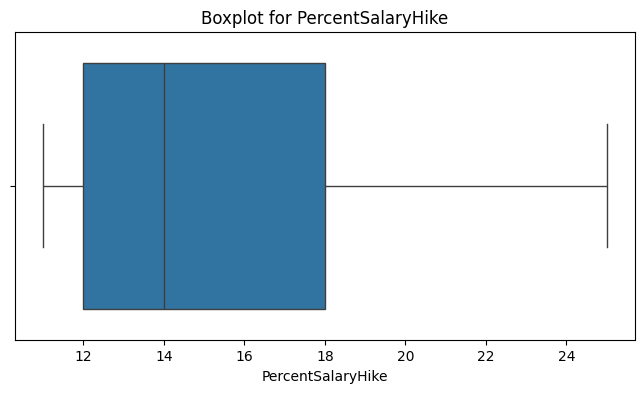

PerformanceRating: 226 potential outliers (lower_bound=3.00, upper_bound=3.00)


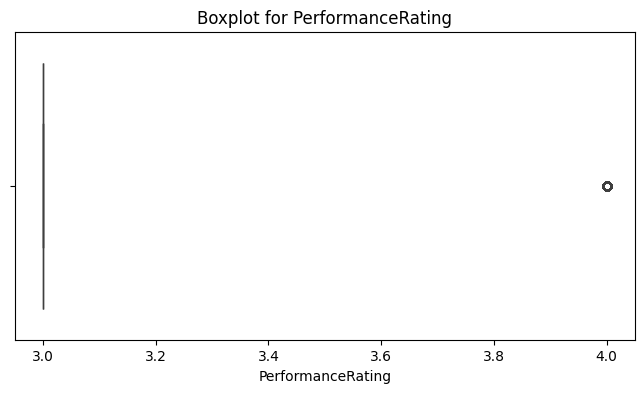

RelationshipSatisfaction: 0 potential outliers (lower_bound=-1.00, upper_bound=7.00)


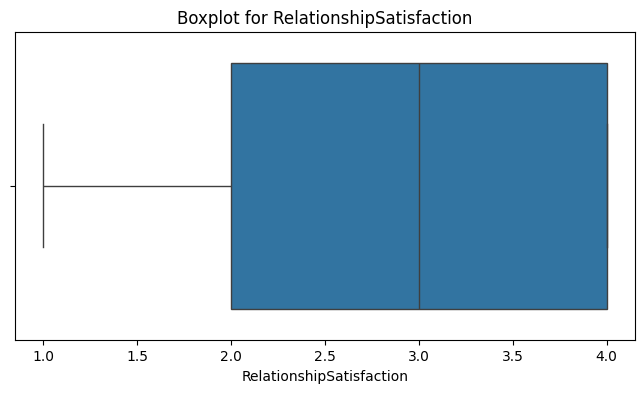

StockOptionLevel: 85 potential outliers (lower_bound=-1.50, upper_bound=2.50)


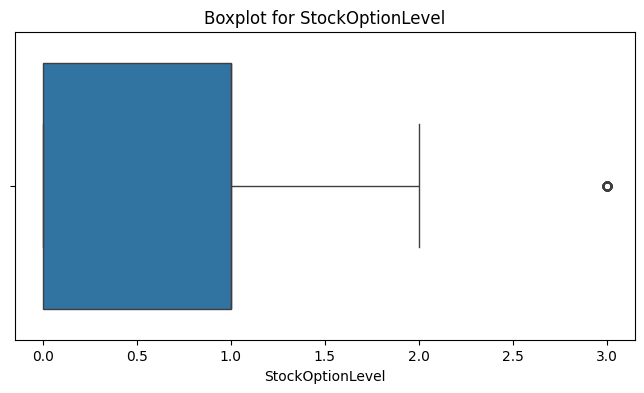

TotalWorkingYears: 63 potential outliers (lower_bound=-7.50, upper_bound=28.50)


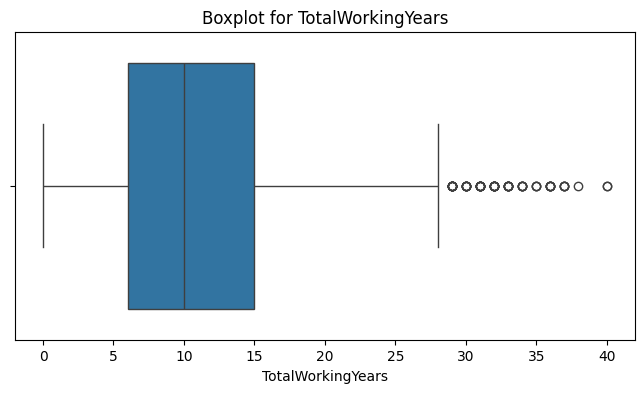

TrainingTimesLastYear: 238 potential outliers (lower_bound=0.50, upper_bound=4.50)


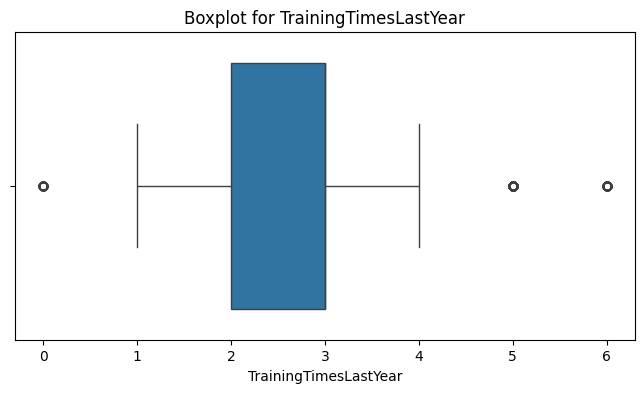

WorkLifeBalance: 0 potential outliers (lower_bound=0.50, upper_bound=4.50)


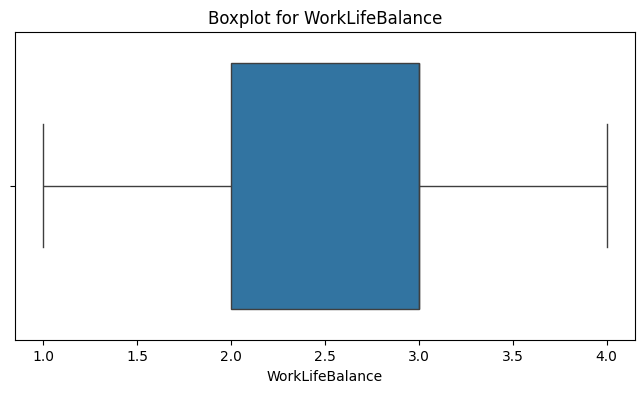

YearsAtCompany: 104 potential outliers (lower_bound=-6.00, upper_bound=18.00)


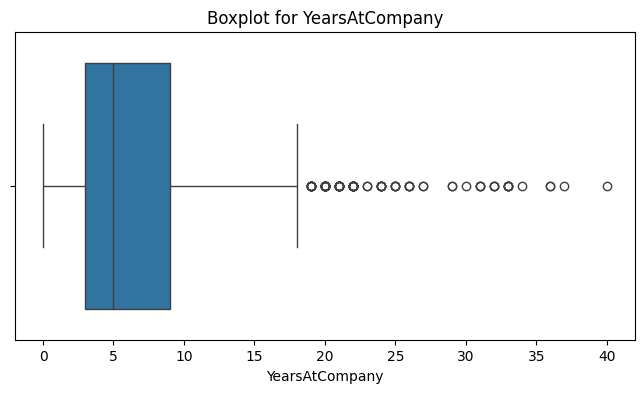

YearsInCurrentRole: 21 potential outliers (lower_bound=-5.50, upper_bound=14.50)


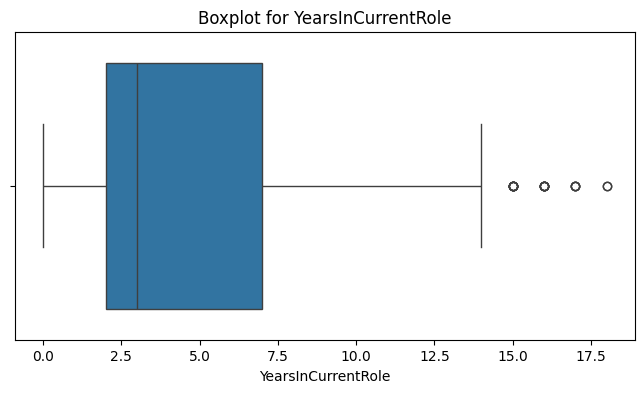

YearsSinceLastPromotion: 107 potential outliers (lower_bound=-4.50, upper_bound=7.50)


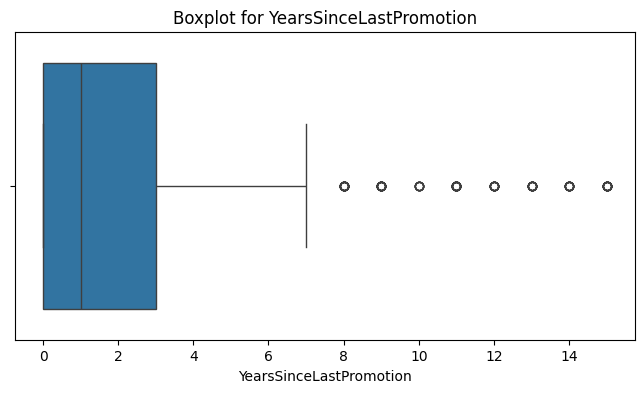

YearsWithCurrManager: 14 potential outliers (lower_bound=-5.50, upper_bound=14.50)


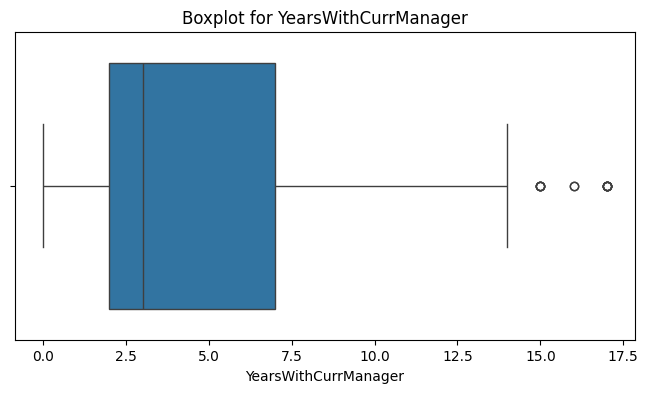

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Loop through each numerical column
for col in numerical_cols:
    # Calculate IQR for the column
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    outlier_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

    # Print the outlier information
    print(f"{col}: {outlier_count} potential outliers (lower_bound={lower_bound:.2f}, upper_bound={upper_bound:.2f})")

    # Plot the boxplot to visualize outliers
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    plt.show()


#### Isolation Forest

In [69]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is your DataFrame loaded with the employee data

# Select numerical features for outlier detection
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Initialize IsolationForest; adjust 'contamination' to reflect the expected proportion of outliers
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model and predict outliers; predictions: 1 for inliers, -1 for outliers
df['outlier_flag'] = iso_forest.fit_predict(df[numerical_cols])

# Count the detected outliers
n_outliers = (df['outlier_flag'] == -1).sum()
print(f"Total outliers detected: {n_outliers}")


display(df[df['outlier_flag'] == -1][numerical_cols])




Total outliers detected: 74


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
45,41,1360,12,3,2,49,3,5,3,19545,...,3,4,0,23,0,3,22,15,15,8
62,50,989,7,2,2,43,2,5,3,18740,...,3,4,1,29,2,2,27,3,13,8
63,59,1435,25,3,1,99,3,3,1,7637,...,3,4,0,28,3,2,21,16,7,9
98,58,682,10,4,4,37,3,4,3,13872,...,3,3,0,38,1,2,37,10,1,8
105,59,1420,2,4,3,32,2,5,4,18844,...,4,4,1,30,3,3,3,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,47,1180,25,3,1,84,3,3,3,8633,...,4,2,0,25,3,3,17,14,12,11
1432,37,161,10,3,3,42,4,3,4,13744,...,4,1,1,16,2,3,16,11,6,8
1443,42,300,2,3,1,56,3,5,3,18880,...,3,1,0,24,2,2,22,6,4,14
1445,41,582,28,4,1,60,2,4,2,13570,...,4,3,1,21,3,3,20,7,0,10


#### Outlier Results 

We compared two methods for outlier detection on our employee attrition dataset. The univariate IQR method flagged hundreds of potential outliers by evaluating each feature independently, this method is sensitive to extreme values on a per-feature basis. In contrast, the multivariate Isolation Forest algorithm, which considers the overall structure and interactions among features, flagged only 75 potential outliers. This indicates that many values deemed extreme by the IQR method fall within a reasonable range when considering the full context of the data.

**Why we decided to keep outliers:**

In our employee attrition modeling context, retaining these outliers is crucial. Extreme values, such as unusually high monthly incomes or long tenures, might capture important, real-world variations that can influence attrition patterns. Removing outliers outright could lead us to lose valuable insights into employee behavior. Furthermore, our modeling approach, particularly if using robust methods like tree-based algorithms, is generally tolerant to these extreme values. Therefore, we decided to retain the outliers in this context

#### Future Pipeline Configuration for Outlier Handling

While we have decided to keep outliers in this initial exploratory analysis, our future modeling pipelines will be configured to rigorously test the impact of both approaches, removing and retaining outliers. This evaluation will be performed across different types of classification models:

- **Models That Might Suffer from Outliers:**
  - **Linear Models (Logistic Regression):** Sensitive to extreme values, which can skew the decision boundary. Removing outliers may help stabilize predictions.
  - **Multi-Layer Perceptron (MLP):** Neural networks like MLPs are also sensitive to outliers due to their reliance on gradient descent for optimization. Extreme values can disrupt the training process, resulting in poor generalization.

- **Models That Might Benefit from Retaining Outliers:**
  - **Tree-Based Models (e.g., Decision Trees, Random Forests, Gradient Boosting):** These models partition data based on feature splits rather than a global fit, making them inherently robust to outliers.
  - **Ensemble Methods:** Can leverage the complete data distribution, including extreme values, to enhance predictive performance.

By integrating both outlier handling strategies in our automated pipelines, we can determine the optimal approach for each classifier. This systematic evaluation ensures that our final model is robust and well-tuned to the complexities of the employee attrition dataset, including future data scenarios where outlier handling becomes crucial.

In [72]:
df.drop(columns=['outlier_flag'], inplace=True)

# EDA

## Numerical Feature Distributions

In our EDA, we begin by examining the data distributions of several key numerical features to gain an initial understanding of their spread and skewness. For instance, we analyze the distributions of DistanceFromHome, MonthlyIncome, NumCompaniesWorked, YearsAtCompany, TotalWorkingYears, YearsInCurrentRole, YearsSinceLastPromotion, and YearsWithCurrManager. This analysis helps us identify whether any of these features are highly skewed, which might suggest the need for transformations like a log transformation to normalize the data.

It is also important to note that some features in our dataset are ordinal, meaning they have an inherent order from 1 to 5. The ordinal columns include Education, EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, and WorkLifeBalance. Since these columns already represent ranked information, applying a log transformation or other non-linear transformations could distort their inherent order.

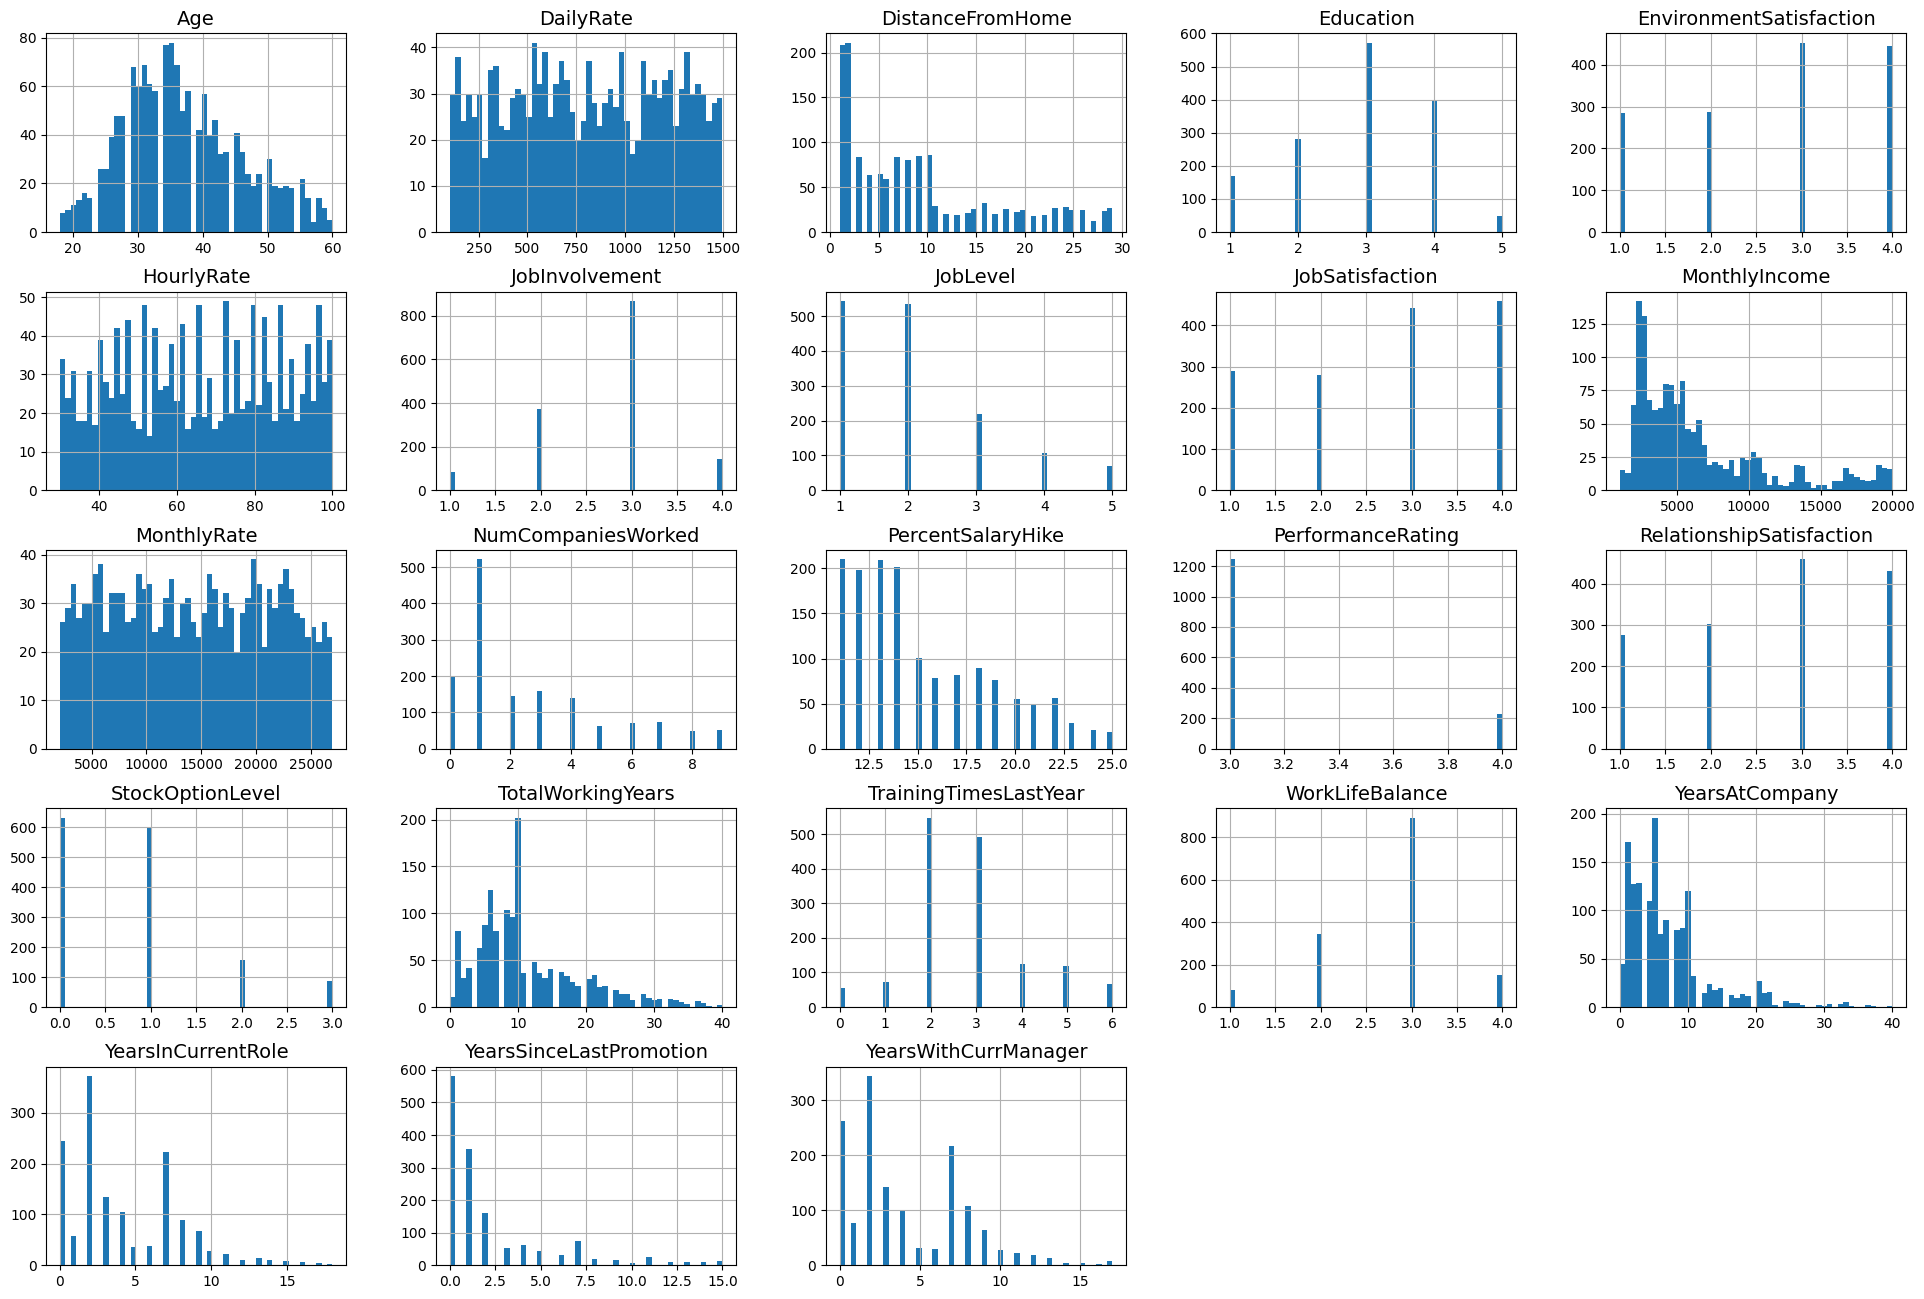

In [ ]:
import matplotlib.pyplot as plt


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(24, 16))
plt.show()

## Correlation & Colinearity

### Correlation Matrix

The correlation matrix reveals several noteworthy relationships among our numerical features. We observe strong correlations among tenure-related variables such as `YearsAtCompany`, `YearsInCurrentRole`, `YearsSinceLastPromotion`, and `YearsWithCurrManager`, indicating these features might be capturing overlapping information. Additionally, the near-perfect correlation between `JobLevel` and `MonthlyIncome` suggests potential redundancy that may require dimensionality reduction or careful **feature selection**. On the other hand, features like `DailyRate` and `DistanceFromHome` exhibit very weak correlations with other variables, implying they might provide unique insights.

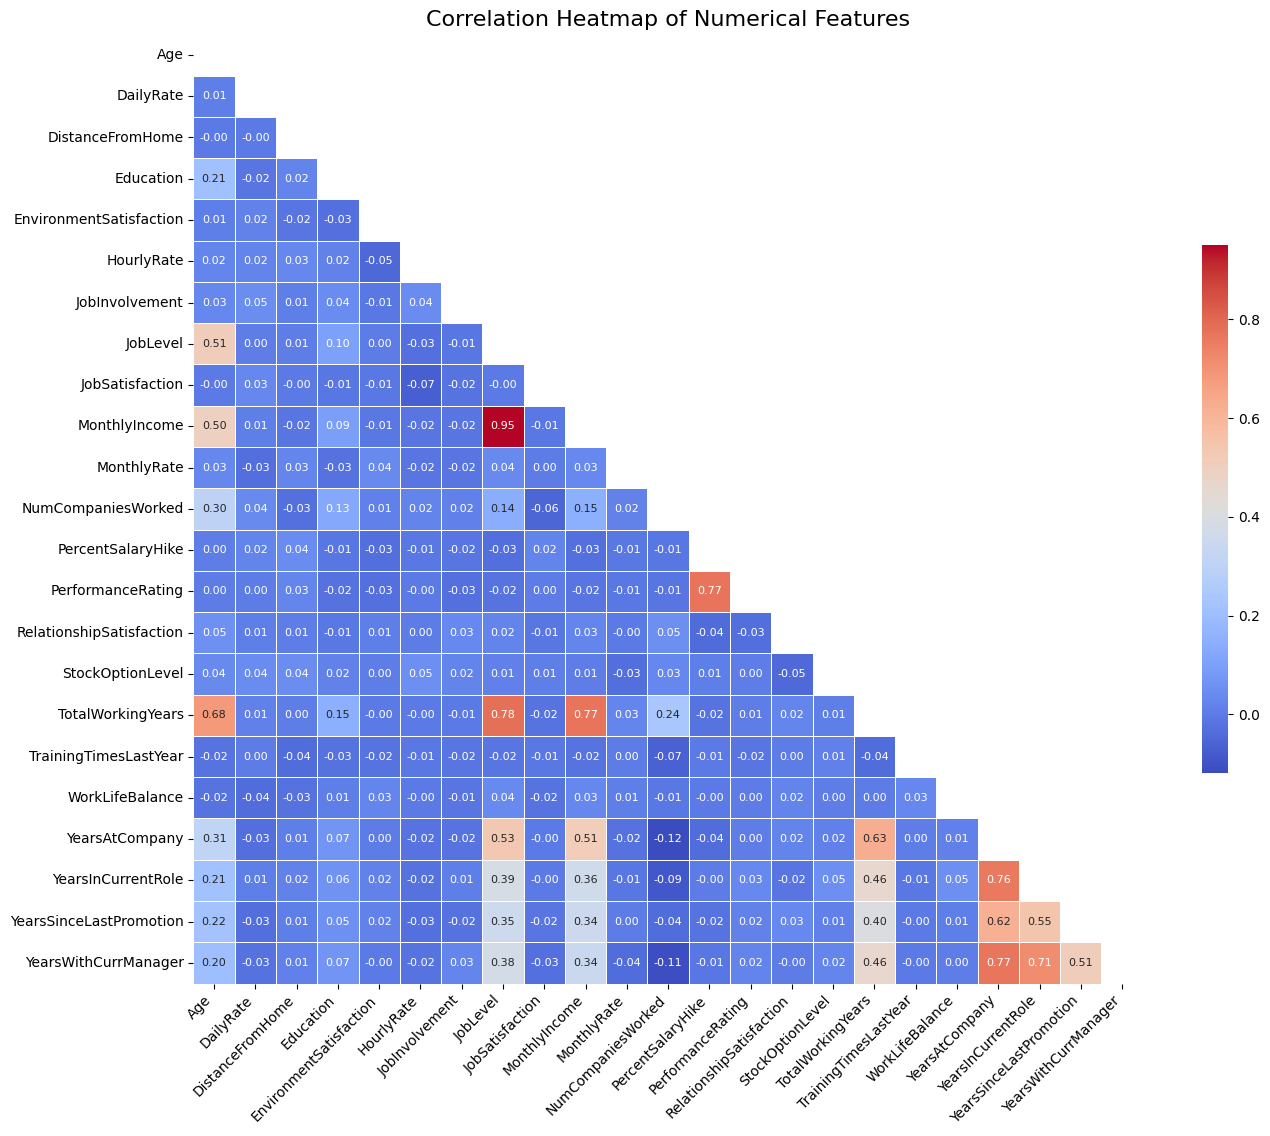

In [53]:
# Compute the correlation matrix for numerical features
corr_matrix = df[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure for a larger plot
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask and custom formatting
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot_kws={"size": 8}
)

plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

### Variance Inflation Factor

These high VIF values signal that many features are highly interrelated, which could lead to unstable coefficient estimates, especially for linear models. 

However, rather than solely removing these collinear features, our strategy is to rigorously test multiple approaches during the modeling stage. We will experiment with:

- **Feature Selection Techniques:** Using methods like Lasso, RFE, and Random Forest feature importance that inherently manage multicollinearity by selecting the most predictive subset of features.
- **Model-Specific Strategies:** Leveraging the robustness of tree-based models and ensemble methods, which are generally less sensitive to multicollinearity.


In [54]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numerical features from the DataFrame
num_df = df.select_dtypes(include=['int64', 'float64']).dropna()

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data['feature'] = num_df.columns
vif_data['VIF'] = [variance_inflation_factor(num_df.values, i) for i in range(num_df.shape[1])]

# Filter features with VIF > 10
high_vif_features = vif_data[vif_data['VIF'] > 10]
print("Features with VIF > 10:")
print(high_vif_features)


Features with VIF > 10:
              feature         VIF
0                 Age   33.155944
5          HourlyRate   11.107000
6      JobInvolvement   14.885028
7            JobLevel   49.657767
9       MonthlyIncome   31.318636
12  PercentSalaryHike   41.829000
13  PerformanceRating  114.724181
16  TotalWorkingYears   14.336803
18    WorkLifeBalance   15.310855
19     YearsAtCompany   10.559993


## Class Imbalance

Our target variable, `Attrition`, exhibits a noticeable class imbalance with approximately **83.9%** of instances belonging to one class and **16.1%** to the other. This disparity can bias model training, often leading to a model that favors the majority class. Such imbalances may result in lower recall or F1-scores for the minority class.

To address this, we will need to incorporate techniques like SMOTE (Synthetic Minority Oversampling Technique) to balance the class distribution in the training set.

/var/folders/pf/lrdbc3y970s_jrm37gglfy180000gn/T/ipykernel_58025/4040860788.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attrition_percentages.index, y=attrition_percentages.values, palette='viridis')


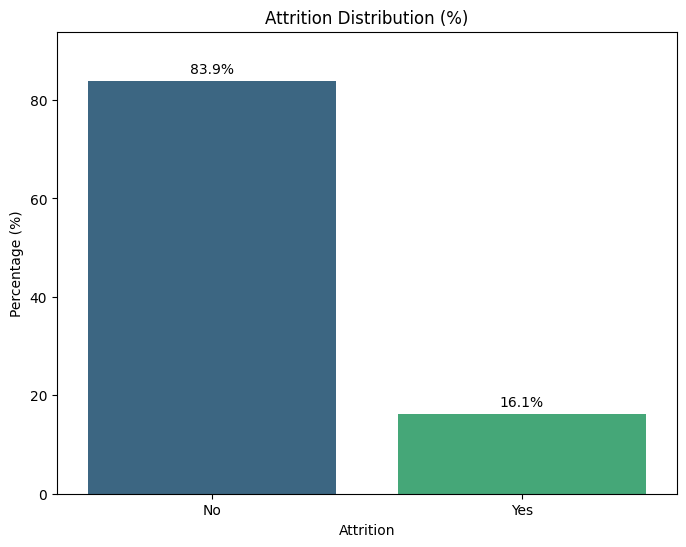

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the percentage for each category in the 'Attrition' column
attrition_percentages = df['Attrition'].value_counts(normalize=True) * 100

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=attrition_percentages.index, y=attrition_percentages.values, palette='viridis')
plt.title('Attrition Distribution (%)')
plt.xlabel('Attrition')
plt.ylabel('Percentage (%)')

# Annotate the bars with percentage values
for i, pct in enumerate(attrition_percentages.values):
    plt.text(i, pct + 1, f"{pct:.1f}%", ha='center', va='bottom')

plt.ylim(0, attrition_percentages.values.max() + 10)
plt.show()



# Splitting the Data

To ensure that the class distribution is maintained in both the training and test sets, we performed a stratified split. This approach guarantees that the **83.9%** to **16.1%** split for `Attrition` is preserved across all subsets of the data. Maintaining consistent class proportions is crucial for reliable model evaluation and to avoid bias towards the majority class.

In [75]:
from sklearn.model_selection import train_test_split


# Split the DataFrame into features (X) and target (y)
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Perform stratified splitting to maintain the same class proportion in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Display the shapes and target distribution in each set
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (1176, 31)
X_test shape: (294, 31)
y_train distribution:
 Attrition
No     0.838435
Yes    0.161565
Name: proportion, dtype: float64
y_test distribution:
 Attrition
No     0.840136
Yes    0.159864
Name: proportion, dtype: float64


# Feature Engineering

## New Feature Engineering: Creating Additional Attributes

In this section, we derive new features that offer deeper insights into the dynamics of employee attrition.

Below are the new attributes we introduce:

- **AgeAtJoining:** Calculated as the difference between `Age` and `YearsAtCompany`, this feature provides insight into the employee's career stage at the time of joining. It may help identify generational trends or early-career attrition risks.
  
- **TenureRatio:** By dividing `YearsAtCompany` by `TotalWorkingYears`, we obtain a ratio that reflects the proportion of an employee's total work experience spent at the current company. A higher ratio might suggest stronger loyalty or limited external experience.
  
- **IncomePerYearExp:** This feature computes the ratio of `MonthlyIncome` to `TotalWorkingYears` to shed light on how compensation scales with overall experience, potentially influencing attrition decisions.


In [76]:
# Create new features for the training set
X_train['AgeAtJoining'] = X_train['Age'] - X_train['YearsAtCompany']
X_train['TenureRatio'] = X_train['YearsAtCompany'] / X_train['TotalWorkingYears'].replace(0, np.nan)
X_train['IncomePerYearExp'] = X_train['MonthlyIncome'] / X_train['TotalWorkingYears'].replace(0, np.nan)

# Replace any NaN values resulting from division by zero
X_train['TenureRatio'] = X_train['TenureRatio'].fillna(0)
X_train['IncomePerYearExp'] = X_train['IncomePerYearExp'].fillna(0)

# Create new features for the test set using the same transformations
X_test['AgeAtJoining'] = X_test['Age'] - X_test['YearsAtCompany']
X_test['TenureRatio'] = X_test['YearsAtCompany'] / X_test['TotalWorkingYears'].replace(0, np.nan)
X_test['IncomePerYearExp'] = X_test['MonthlyIncome'] / X_test['TotalWorkingYears'].replace(0, np.nan)

# Replace any NaN values in the test set as well
X_test['TenureRatio'] = X_test['TenureRatio'].fillna(0)
X_test['IncomePerYearExp'] = X_test['IncomePerYearExp'].fillna(0)

## Skewness and Transformations

We calculated the skewness for all numerical features in the training set and sorted them to understand their distributions. Then, we identified features with an absolute skewness greater than 0.75, excluding the ordinal columns, to pinpoint which variables could benefit from transformation (We will test between log and Box-Cox). This process produces a list of candidate features for further normalization.

In [77]:
# Step 1: Identify numerical features and calculate skewness
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
# Compute skewness for each numerical feature
skewness_series = X_train[numerical_features].apply(lambda x: skew(x.dropna()))
# Sort the skewness values for clarity
skewness_series = skewness_series.sort_values(ascending=False)

print("Skewness of numerical features:")

print(skewness_series)

ordinal_cols = [
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
    'JobLevel', 'JobSatisfaction', 'PerformanceRating',
    'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
]

# Step 2: Determine which features are highly skewed using a threshold (e.g., 0.75)
threshold = 0.75
# Create a list of feature names whose absolute skewness exceeds the threshold
highly_skewed_features = [feature for feature in skewness_series.index
                          if abs(skewness_series[feature]) > threshold and feature not in ordinal_cols]


print("\nFeatures to log transform:", highly_skewed_features)

Skewness of numerical features:
IncomePerYearExp            2.350746
YearsSinceLastPromotion     1.968349
PerformanceRating           1.882402
YearsAtCompany              1.730686
MonthlyIncome               1.331249
TotalWorkingYears           1.102298
NumCompaniesWorked          0.997796
JobLevel                    0.978058
StockOptionLevel            0.968522
DistanceFromHome            0.927036
YearsInCurrentRole          0.871814
PercentSalaryHike           0.805633
YearsWithCurrManager        0.777045
AgeAtJoining                0.745509
TrainingTimesLastYear       0.613346
Age                         0.403172
MonthlyRate                 0.002710
DailyRate                  -0.004038
HourlyRate                 -0.010065
Education                  -0.296723
JobSatisfaction            -0.325564
RelationshipSatisfaction   -0.327549
EnvironmentSatisfaction    -0.328060
JobInvolvement             -0.520605
WorkLifeBalance            -0.569558
TenureRatio                -0.664573
dtype:

### Log Transformation

Log transformation is a straightforward method to reduce right skewness in strictly positive data. By applying np.log1p(x), we stabilize variance and make the data more normally distributed.

In [ ]:
# Step 3: Apply log transformation to these features using np.log1p
X_train_log = X_train.copy()
for feature in highly_skewed_features:
    X_train_log[feature] = np.log1p(X_train_log[feature])

X_test_log = X_test.copy()
for feature in highly_skewed_features:
    X_test_log[feature] = np.log1p(X_test_log[feature])


new_skewness = X_train_log[highly_skewed_features].apply(lambda x: skew(x.dropna()))
print("\nSkewness in train set after log transformation:")
print(new_skewness.sort_values(ascending=False))



Skewness in train set after log transformation:
YearsSinceLastPromotion    0.719406
PercentSalaryHike          0.499931
MonthlyIncome              0.251454
NumCompaniesWorked         0.076533
DistanceFromHome          -0.060397
YearsAtCompany            -0.225298
YearsWithCurrManager      -0.388767
YearsInCurrentRole        -0.403287
TotalWorkingYears         -0.633388
dtype: float64


### Box-Cox Transformation

Box-Cox transformation is a flexible power transformation that optimizes a parameter λ to best normalize a dataset. It is ideal for continuous, strictly positive data and can often achieve better normality than a simple log transformation.

In [ ]:
from scipy.stats import boxcox

# Copy the training set for Box-Cox transformation
X_train_boxcox = X_train.copy()
for feature in highly_skewed_features:
    # Ensure the data is strictly positive by shifting if necessary
    if X_train_boxcox[feature].min() <= 0:
        shift = abs(X_train_boxcox[feature].min()) + 1
    else:
        shift = 0
    # Apply the Box-Cox transformation; boxcox returns (transformed_data, lambda)
    X_train_boxcox[feature] = boxcox(X_train_boxcox[feature] + shift)[0]

# Do the same for the test set
X_test_boxcox = X_test.copy()
for feature in highly_skewed_features:
    if X_test_boxcox[feature].min() <= 0:
        shift = abs(X_test_boxcox[feature].min()) + 1
    else:
        shift = 0
    X_test_boxcox[feature] = boxcox(X_test_boxcox[feature] + shift)[0]

new_skewness_boxcox = X_train_boxcox[highly_skewed_features].apply(lambda x: skew(x.dropna()))
print("\nSkewness in train set after Box-Cox transformation:")
print(new_skewness_boxcox.sort_values(ascending=False))



Skewness in train set after Box-Cox transformation:
IncomePerYearExp           0.284691
YearsSinceLastPromotion    0.214688
PercentSalaryHike          0.110171
MonthlyIncome              0.029312
NumCompaniesWorked         0.012661
YearsAtCompany            -0.008526
TotalWorkingYears         -0.010390
YearsInCurrentRole        -0.064475
DistanceFromHome          -0.067623
YearsWithCurrManager      -0.074059
dtype: float64


## Scaling: Standardization

Given our dataset with features like MonthlyIncome and YearsAtCompany spanning a wide range, standardization is generally preferred over MinMax scaling. Standardization is well-suited for algorithms such as logistic regression, and MLP. 

**However, we will test both methods in our modeling pipelines to determine which scaling strategy yields the best performance.**

In [59]:

# Identify numerical columns in the log-transformed datasets
numeric_cols = X_train_log.select_dtypes(include=["int64", "float64"]).columns


X_train_log_std = X_train_log.copy()
X_test_log_std = X_test_log.copy()

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training numeric data and transform it
X_train_log_std[numeric_cols] = scaler.fit_transform(X_train_log[numeric_cols])

# Transform the test numeric data using the same scaler (without refitting)
X_test_log_std[numeric_cols] = scaler.transform(X_test_log[numeric_cols])

# Optional: Display the first few rows to verify the scaling
print("First five rows of standardized numerical features in X_train_log:")
print(X_train_log[numeric_cols].head())


First five rows of standardized numerical features in X_train_log:
      Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
1194   47       1225          1.098612          4                        2   
128    22        594          1.098612          1                        3   
810    46        406          1.386294          1                        1   
478    25        622          2.639057          1                        2   
491    43       1001          2.302585          5                        4   

      HourlyRate  JobInvolvement  JobLevel  JobSatisfaction  MonthlyIncome  \
1194          47               4         4                2       9.678655   
128          100               3         1                4       7.833600   
810           52               3         4                3       9.768011   
478           40               3         1                3       7.648263   
491           72               3         2                3       8.644707

## Encoding Categoricals

### Categorical Encoding

We begin by identifying and one-hot encoding our categorical columns to convert them into binary features.

In [80]:
# Encoding of Features and Target Variable

# Identify categorical columns in the log-transformed training set
categorical_cols = X_train_log.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

# One-hot encode categorical columns in the log-transformed datasets
X_train_log_std_encoded = pd.get_dummies(X_train_log_std, columns=categorical_cols, drop_first=True)
X_test_log_std_encoded = pd.get_dummies(X_test_log_std, columns=categorical_cols, drop_first=True)




Categorical columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


### Alternative: Categorical Encoding and Ordinal Encoding where Applicable

For our alternative encoding strategy, we replace one-hot encoding for the `BusinessTravel` column with ordinal encoding. Although the ordering in `BusinessTravel` (i.e., `'Non-Travel'`, `'Travel_Rarely'`, `'Travel_Frequently'`) may not be strictly linear, this approach allows us to test whether preserving a rank-like order improves model performance.

This encoding is applied only to `BusinessTravel`, while the remaining categorical variables continue to use one-hot encoding. By testing this strategy within our modeling pipelines, we can determine if the ordinal representation of `BusinessTravel` offers any performance benefits.

In [82]:
mapping = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
X_train_log_std['BusinessTravel'] = X_train_log_std['BusinessTravel'].map(mapping)
X_test_log_std['BusinessTravel'] = X_test_log_std['BusinessTravel'].map(mapping)

categorical_cols = X_train_log_std.select_dtypes(include=['object']).columns.tolist()

X_train_log_std_encoded = pd.get_dummies(X_train_log_std, columns=categorical_cols, drop_first=True)
X_test_log_std_encoded = pd.get_dummies(X_test_log_std, columns=categorical_cols, drop_first=True)

### Label Encoding of Target Variable

In [61]:
# Encode the target variable using LabelEncoder (for binary classification)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Mapping of classes:", dict(zip(le.classes_, range(len(le.classes_)))))

Mapping of classes: {'No': 0, 'Yes': 1}


# SMOTE - Oversampling the Underrepresented Data

When dealing with class imbalance, where one class is significantly underrepresented (in our case, 16.1% for Attrition versus 83.9%), the model may become biased towards the majority class. This can lead to poor predictive performance for the minority class, which is often the primary focus in attrition prediction.

We use SMOTE (Synthetic Minority Oversampling Technique) to address this imbalance. Unlike simple replication of minority instances, SMOTE generates synthetic samples based on existing data. This helps provide a more diverse and robust set of examples, reducing the risk of overfitting while ensuring the model has enough information to learn from both classes.

In [62]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE; note: apply SMOTE only on the training data
smote = SMOTE(random_state=42)

# Apply SMOTE on the training set
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_log_std_encoded, y_train_encoded)

# Display the class distribution after SMOTE
print("Distribution in y_train before SMOTE:")
print(pd.Series(y_train_encoded).value_counts(normalize=True) * 100)

print("\nDistribution in y_train after SMOTE:")
print(pd.Series(y_train_balanced).value_counts(normalize=True) * 100)


Distribution in y_train before SMOTE:
0    83.843537
1    16.156463
Name: proportion, dtype: float64

Distribution in y_train after SMOTE:
0    50.0
1    50.0
Name: proportion, dtype: float64


# Feature Selection

In this section, we focus on identifying the most relevant predictors from our dataset to improve model performance, reduce dimensionality, and mitigate multicollinearity. By comparing various methods within our modeling pipelines, we can determine which feature subset leads to the best predictive performance for employee attrition.

### LassoCV Feature Selection

LassoCV applies L1 regularization with cross-validation, shrinking coefficients of less important features to zero. By selecting only features with non-zero coefficients, we effectively reduce dimensionality while mitigating multicollinearity.

In [64]:
from sklearn.linear_model import LassoCV

# Fit LassoCV (with cross-validation) on the training data
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_balanced, y_train_balanced)

# Create a Series of coefficients indexed by feature names
lasso_coef = pd.Series(lasso.coef_, index=X_train_balanced.columns)

# Select features with non-zero coefficients
selected_features_lasso = lasso_coef[lasso_coef != 0].index.tolist()
print("Selected features by Lasso:", selected_features_lasso)

Selected features by Lasso: ['Age', 'DailyRate', 'HourlyRate', 'MonthlyRate']


### RFE (Recursive Feature Elimination)

RFE iteratively removes the least important features based on the performance of a base estimator. Here, we use Logistic Regression as the estimator and select the top 10 features. This method helps identify a subset of features that contribute most to the predictive power of the model.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Instantiate a base estimator; LogisticRegression works well for classification.
lr = LogisticRegression(max_iter=500, random_state=42)

# Set the number of features you wish to select (adjust n_features_to_select as needed)
rfe = RFE(estimator=lr, n_features_to_select=10)
rfe.fit(X_train_balanced, y_train_balanced)

# Get the mask and list of selected features
selected_features_rfe = X_train_balanced.columns[rfe.support_].tolist()
print("Selected features by RFE:", selected_features_rfe)


### Random Forest Feature Importance

We use a RandomForestClassifier to rank features based on their importance scores. Instead of selecting a fixed number of top features, we compute the median importance value and retain only those features whose importance exceeds the median. This dynamic threshold allows us to adapt to the dataset's characteristics.

In [83]:
from sklearn.ensemble import RandomForestClassifier

# Train a RandomForestClassifier on the balanced training data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

# Create a Series of feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train_balanced.columns)

# Compute the median importance
median_importance = feature_importances.median()
# Select features with importance greater than the median
selected_features_rf = feature_importances[feature_importances > median_importance].index.tolist()
print("Selected features by Tree Importance (median threshold):", selected_features_rf)


Selected features by Tree Importance (median threshold): ['Age', 'DailyRate', 'DistanceFromHome', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently', 'Department_Sales', 'JobRole_Laboratory Technician', 'MaritalStatus_Single', 'OverTime_Yes']


# Testing Base Gradient Boosting

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Instantiate Gradient Boosting model with default hyperparameters
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model on the SMOTE-balanced dataset
gb_model.fit(X_train_balanced, y_train_balanced)


GradientBoostingClassifier(random_state=42)

In [68]:
# Predictions on the training set
y_train_pred = gb_model.predict(X_train_balanced)

# Predictions on the test set
y_test_pred = gb_model.predict(X_test_log_std_encoded)

# Compute performance metrics
train_acc = accuracy_score(y_train_balanced, y_train_pred)
test_acc = accuracy_score(y_test_encoded, y_test_pred)

train_f1 = f1_score(y_train_balanced, y_train_pred)
test_f1 = f1_score(y_test_encoded, y_test_pred)

train_auc = roc_auc_score(y_train_balanced, gb_model.predict_proba(X_train_balanced)[:, 1])
test_auc = roc_auc_score(y_test_encoded, gb_model.predict_proba(X_test_log_std_encoded)[:, 1])

# Display results
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
print(f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")
print("\nTest Set Classification Report:\n", classification_report(y_test_encoded, y_test_pred))


Train Accuracy: 0.9746, Test Accuracy: 0.8571
Train F1 Score: 0.9743, Test F1 Score: 0.4615
Train AUC: 0.9943, Test AUC: 0.7904

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       247
           1       0.58      0.38      0.46        47

    accuracy                           0.86       294
   macro avg       0.74      0.67      0.69       294
weighted avg       0.84      0.86      0.84       294



These results indicate that while the model fits the training data very well (with high accuracy and AUC), its performance on the test set especially for the minority class (Attrition = 1) is less robust. The lower test F1 score and AUC for the minority class suggest that, despite the balanced training achieved by SMOTE, there is still room for improvement in handling class imbalance and ensuring better generalization. This baseline performance will serve as a benchmark when testing different preprocessing and feature selection strategies in our modeling pipelines.

# Next Steps

With our current preprocessing, feature engineering, and baseline modeling completed, the next phase is to explore comprehensive modeling pipelines. In the upcoming notebook, **predictive_modeling_f2.ipynb**, we will:

- **Optimize Preprocessing Pipelines:**  
  Use grid search to identify the best preprocessing configuration for each classifier.

- **Hyperparameter Tuning:**  
  Select the optimal pipeline for each classifier and then fine-tune the model hyperparameters.

- **Build a Stacking Model:**  
  Combine the best-performing classifiers to create a stacking model for improved predictive performance.

Please proceed to **predictive_modeling_f2.ipynb** to continue with these experiments and further refine our predictive models.